In [223]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset, DataLoader

PATH = "kaggle_3m"
IMAGE_SIZE = (256, 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

paths = []

for dirname in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, dirname)):
        
        for filename in os.listdir(os.path.join(PATH, dirname)):
            if filename.endswith('.tif'):
                paths.append(PATH+'/'+dirname+'/'+filename)


def data_frame(data):
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    pixels = lambda x: Image.open(x)
    largest_pixel = lambda y: np.max(pixels(y))
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    data_df = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})
    
    train_index, val_index = train_test_split(data_df.index.values.tolist(), test_size=0.19, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.12, random_state=42)
    
    # Making train, test, and validation dataframes
    train_df, val_df, test_df = data_df.iloc[train_index], data_df.iloc[val_index], data_df.iloc[test_index]
    
    return train_df, val_df, test_df
    
# Making the dataframes
train_df, val_df, test_df = data_frame(paths)

print(len(train_df), len(val_df), len(test_df))

print(train_df.head())

def tensor_from_path(path):
    arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    arr = cv2.resize(arr, IMAGE_SIZE)
    arr = arr / 255
    if len(arr.shape) == 3:
        tensor = torch.tensor(arr).permute(2,0,1)
    elif len(arr.shape) == 2:
        tensor = torch.tensor(arr).unsqueeze(0)
    else:
        raise ValueError(f"Expected data shape to be (..., ..., 3) or (..., ...) , but got {arr.shape}")
    return tensor

class data(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df        
        self.images = self.df.loc[:,'Image'].values
        self.masks = self.df.loc[:,'Mask'].values
        self.diagnosis = self.df.loc[:,'Diagnosis'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im_path = self.images[idx]
        msk_path= self.masks[idx]
        diagnosis = self.diagnosis[idx]
        self.im_tensor = tensor_from_path(im_path)
        self.msk_tensor= tensor_from_path(msk_path)
        return self.im_tensor.to(device), self.msk_tensor.to(device),diagnosis

train_ds = data(train_df)
test_ds = data(test_df)

train_dl = DataLoader(train_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

import torch
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 61 * 61, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        '''
        starts at torch.Size([4, 3, 256, 256])
        torch.Size([4, 6, 252, 252])
        torch.Size([4, 6, 126, 126])
        torch.Size([4, 16, 122, 122])
        torch.Size([4, 16, 61, 61])`
        then flattens to NN
        '''
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net().to(device)




cuda
3182 657 90
                            ID  \
812   TCGA_DU_7302_19911203_33   
1550  TCGA_HT_7602_19951103_17   
2228  TCGA_DU_A5TR_19970726_31   
1108  TCGA_DU_5872_19950223_26   
3728  TCGA_FG_7643_20021104_17   

                                                  Image  \
812   kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_1...   
1550  kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_1...   
2228  kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...   
1108  kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...   
3728  kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_2...   

                                                   Mask  Diagnosis  
812   kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_1...          0  
1550  kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_1...          0  
2228  kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1...          0  
1108  kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_1...          0  
3728  kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_2...          0  


In [224]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

dataloader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)

for epoch in range(7):
    correct = 0
    total = 0
    current_predicted = 0
    current_total = 0
    for i, data in enumerate(dataloader, 0):

        inputs, _,labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = net(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        predicted = torch.round(outputs.data) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        current_total += labels.size(0)
        current_predicted += (predicted == labels).sum().item()
        if i % 100 == 0:
            print('epoch',epoch)
            print('Current accaracy: %d %%' % (100 * current_predicted / current_total))
            print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
            current_predicted = 0
            current_total = 0


print('Finished Training')


epoch 0
Current accaracy: 50 %
Accuracy of the network on the train images: 50 %
epoch 0
Current accaracy: 66 %
Accuracy of the network on the train images: 65 %
epoch 0
Current accaracy: 71 %
Accuracy of the network on the train images: 68 %
epoch 0
Current accaracy: 75 %
Accuracy of the network on the train images: 71 %
epoch 0
Current accaracy: 78 %
Accuracy of the network on the train images: 72 %
epoch 0
Current accaracy: 78 %
Accuracy of the network on the train images: 73 %
epoch 0
Current accaracy: 78 %
Accuracy of the network on the train images: 74 %
epoch 0
Current accaracy: 78 %
Accuracy of the network on the train images: 75 %
epoch 1
Current accaracy: 75 %
Accuracy of the network on the train images: 75 %
epoch 1
Current accaracy: 80 %
Accuracy of the network on the train images: 80 %
epoch 1
Current accaracy: 82 %
Accuracy of the network on the train images: 81 %
epoch 1
Current accaracy: 87 %
Accuracy of the network on the train images: 83 %
epoch 1
Current accaracy: 82

KeyboardInterrupt: 

In [226]:
net.eval()
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=True)

from sklearn.metrics import precision_score, recall_score

correct = 0
total = 0
all_predicted = []
all_labels = []

for data in test_dataloader:
    images,_, labels = data
    images = images.float().to(device)
    labels = labels.float().to(device)
    outputs = net(images).squeeze()
    predicted = torch.round(outputs.data) #to add more precision
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    all_predicted.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calculate accuracy, precision, and recall
accuracy = 100 * correct / total
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)

# Print the results
print('Accuracy of the network on the test images: %d %%' % accuracy)
print('Precision of the network on the test images: %f' % precision)
print('Recall of the network on the test images: %f' % recall)






Accuracy of the network on the test images: 92 %
Precision of the network on the test images: 0.931034
Recall of the network on the test images: 0.843750


In [ ]:
%pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


(1, 256, 256)
(1, 256, 256)
(1, 256, 256)
(1, 256, 256)


100%|██████████| 1/1 [00:00<00:00, 41.13it/s]

(1, 256, 256)


(1, 256, 256)


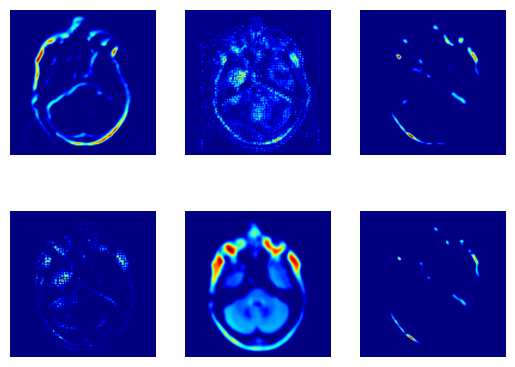

In [259]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import matplotlib.pyplot as plt


path = 'kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_7.tif'
target_layers = [net.conv2]
input_tensor = tensor_from_path(path).float().to(device)
input_tensor = input_tensor.unsqueeze(0)

rgb_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
rgb_img = cv2.resize(rgb_img, IMAGE_SIZE)
rgb_img = np.array(rgb_img,dtype=np.float32)
rgb_img /= 256

fig,ax=plt.subplots(nrows=2,ncols=3)
i = 0
methods = [GradCAM,HiResCAM,FullGrad,EigenCAM,AblationCAM, GradCAMPlusPlus]
for method in methods:
    cam = method(model=net, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)
    print(grayscale_cam.shape)
    grayscale_cam = grayscale_cam[0, :]


    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True,image_weight=0)

    ax[i%2][i//2].axis('off')
    ax[i%2][i//2].imshow(visualization)
    i+=1
    plt.plot()